In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats
import seaborn as sns
import scipy.stats as ss

# Make plots larger
plt.rcParams['figure.figsize'] = (15, 9)

In [2]:
AAPL = pd.read_csv('AAPL_New.csv')
AAPL.set_index('Date')
AAPL['open_tmr'] = AAPL['Open'].shift(-1)
AAPL['OpenClose']= (AAPL['Open']+ AAPL['Close'])/2
AAPL['HighLow'] = (AAPL['High']+ AAPL['Low'])/2
AAPL['OCHL'] = (AAPL['Open']+ AAPL['Close']+AAPL['High']+ AAPL['Low'])/4
AAPL.head()

,Date,High,Low,Open,Close,Volume,Adj Close,open_tmr,OpenClose,HighLow,OCHL
0,1/4/2016,105.370003,102.000000,102.610001,105.349999,67649400,98.446655,105.750000,103.980000,103.685001,103.832500
1,1/5/2016,105.849999,102.410004,105.750000,102.709999,55791000,95.979675,100.559998,104.230000,104.130001,104.180000
2,1/6/2016,102.370003,99.870003,100.559998,100.699997,68457400,94.101387,98.680000,100.629997,101.120003,100.875000
3,1/7/2016,100.129997,96.430000,98.680000,96.449997,81094400,90.129868,98.550003,97.564999,98.279999,97.922499
4,1/8/2016,99.110001,96.760002,98.550003,96.959999,70798000,90.606438,98.970001,97.755001,97.935001,97.845001


In [3]:
#T = 670
X = AAPL[['OpenClose']].as_matrix()[1:]
Y = AAPL[['open_tmr']].as_matrix()[:-1]
df = AAPL[['Close']]
df.reset_index(level=0, inplace=True)
df.columns=['ds','y']
#X = np.column_stack([np.ones((T,1)),X])
#print(X.transpose().shape)
#movAverage1= (movAvg) 
X.shape

C:\Users\kaila\Anaconda3\envs\tensorflow_gpuenv\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
C:\Users\kaila\Anaconda3\envs\tensorflow_gpuenv\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until


(987, 1)

In [4]:
def Linear(X, Y):
    
    T = X.shape[0]
    #print(T)
    #mu = (AAPL['Open '].mean(),AAPL['Open '].mean(),AAPL['Open '].mean()) 
    #cov = [[1,0.75,-0.35],[0.75,1,0.9],[-0.35,0.9,1]]
    #F = np.random.multivariate_normal(mu,cov,T)
    #Sample for Y,X
    X = np.column_stack([np.ones((T,1)),X])
    #T = X.shape[0]
    N = X.shape
    #print(N)
    #beta = np.array([0.56,2.53,2.05,1.78])
    #beta.shape=(N[1],1)
    #Y =X@beta+np.random.normal(0,1,(T,1))
    #Y=AAPL['Open '].values
    #print(T)
    invXX = np.linalg.inv(X.transpose()@X)
    #print(invXX.shape)
    #print(X.shape)
    beta_hat = invXX@X.transpose()@Y
    #print(beta_hat)
    y_hat = X@beta_hat
#     residuals = Y-y_hat
#     sigma2 = (1/T)*residuals.transpose()@residuals

#     sigma = np.sqrt(sigma2)

#     #variance - covariance of beta_hat
#     varcov_beta_hat = (sigma2)*invXX
#     std_beta_hat = np.sqrt(T*np.diag(varcov_beta_hat))

#     R_square = 1-(residuals.transpose()@residuals)/(T*np.var(Y))

#     adj_R_square = 1-(1-R_square)*(T-1)/(T - N[1])

#     #Testing Coefficents:beta_i
#     #Null Hypotesis

#     t_stat = (beta_hat.transpose()-0)/std_beta_hat
#     p_val = 1-ss.norm.cdf(t_stat)

#     #Test of joint significance
#     F_stat= (beta_hat.transpose()@np.linalg.inv(varcov_beta_hat)@beta_hat/N[1])/(residuals.transpose()@residuals/(T-N[1]))
#     p_val_F= 1 - ss.f.cdf(F_stat,N[1]-1, T-N[1])
    
    return beta_hat,y_hat


In [5]:
y_hat = Linear(X, Y)[1]

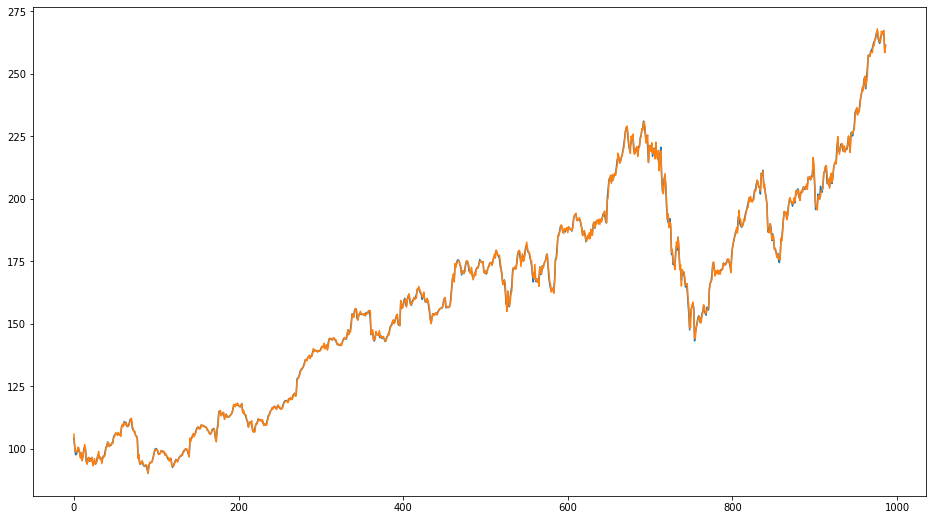

In [6]:
plt.figure(figsize = (16,9))
plt.plot(y_hat)
plt.plot(Y)

In [7]:
def linear_bootstrap():
    T = 250
    #print(T)
    N = X.shape[0]
    #print(N)
    
    yhat_linear = np.zeros(N-(T+1))
    window = 200
    num_boost = 300 # increase
    
    for t in range(T+1,N):
        X_train = df.y.ewm(span=5, adjust=False).mean()[t-window:t-1]
        #X_train = np.column_stack([np.ones((len(X_train),1)),X_train])
        Y_train = AAPL[['open_tmr']][t-window:t-1].values
        #print(X_train.shape)
        #print(Y_train.shape)
        X_pred = df.y.ewm(span=5, adjust=False).mean()[t-1:t]
        X_pred = np.column_stack([np.ones((len(X_pred),1)),X_pred])
        
        yhat_train = Linear(X_train , Y_train)[1]
        res_train = Y_train - yhat_train
       
        y_pred_all = np.zeros(num_boost)
       
        for i in range (0,num_boost):
            #err = np.random.choice(res_train,(window-1, ),replace = True)
            err = res_train
            y_bstr = yhat_train + err
            beta_bstr = Linear(X_train,y_bstr)[0]
            #print(X_pred.shape)
            #print(beta_bstr.shape)
 
            y_pred_bstr = X_pred@beta_bstr
            y_pred_all[i] = y_pred_bstr
           
        y_pred_linear = y_pred_all.mean()
       
        yhat_linear[t-(T+1)] = y_pred_linear
   
   
    rmse_linear = np.sqrt(np.mean((Y - yhat_linear)**2))
   
    return yhat_linear,rmse_linear

In [8]:
rmse_linear = linear_bootstrap()[1]
rmse_linear

56.25059752896193